# **Estimation of the vehicle mass with neural recursive least squares**

## Initialization

### Import packages

In [2]:
import sys
import os
import torch
import pandas as pd
import scipy as sp

print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))
from neu4mes import *
from neu4mes import relation
from neu4mes import earlystopping
relation.NeuObj_names = []  # reset the list of NeuObj names

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()


Current working directory:  /Users/mattiapiccinini/Documents/Research/Neu4Mes/Neu4Mes/tutorials
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>---- neu4mes ----<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


### Configurations and known constant parameters

In [3]:
# Path to the data folder
data_folder = os.path.join(os.getcwd(),'datasets','estimate_vehicle_mass')

# Import the file with the vehicle data
vehicle_data_csv = os.path.join(data_folder,'other_data','vehicle_data.csv')

## NN model

### Custom parametric functions

In [4]:
# -------------------------------------------------
# Absolute value function
# -------------------------------------------------
def abs_fun(x):
  return torch.abs(x)

# -------------------------------------------------
# Saturation function
# -------------------------------------------------
def sat_fun(x,x_min,x_max):
  return torch.min(torch.max(x,x_min),x_max)

# -------------------------------------------------
# Lateral force model (pseudo-neural)
# -------------------------------------------------
def Fy_model(ay, ax,      # inputs
             ay_0, ax_0,  # constants (centers of this local model)
             weights      # learnable array of weights
             ):
  sign_ay = torch.sign(ay)  # sign of the lateral acceleration

  # weights defining the local model for ay
  qy_1 = weights[0,0,0]
  qy_2 = weights[0,0,1]
  qy_3 = weights[0,0,2]
  qy_4 = weights[0,0,3]
  qy_5 = weights[0,0,4]
  qy_6 = weights[0,0,5]
  # weights defining the local model for ax
  qx_1 = weights[0,0,6]
  qx_2 = weights[0,0,7]
  qx_3 = weights[0,0,8]
  qx_4 = weights[0,0,9]
  qx_5 = weights[0,0,10]
  qx_6 = weights[0,0,11]
  qx_7 = weights[0,0,12]

  # model output
  output = (qy_1 + qy_2*(ay - ay_0*sign_ay) + qx_1*(ax - ax_0) + qx_2*torch.pow(ax - ax_0,2) + \
            qy_3*qx_3*(ay - (qy_4+ay_0)*sign_ay)*(qx_4 + ax - ax_0)) * \
           (1 + qy_5*(ay - ay_0*sign_ay) + qx_5*(ax - ax_0) + qx_6*torch.pow(ax - ax_0,2) + \
            qy_6*qx_7*(ay - ay_0*sign_ay)*(ax - ax_0)) 
  return output

# -------------------------------------------------
# Rolling resistance model (pseudo-neural)
# -------------------------------------------------
def Fr_model(vx, ay, ax,  # inputs
             ay_0, ax_0,  # constants (centers of this local model)
             weights      # learnable array of weights
            ):
  sign_ay = torch.sign(ay)  # sign of the lateral acceleration

  # weights defining the local model for ay
  fv_1 = weights[0,0,0]
  fv_2 = weights[0,0,1]
  s_0  = weights[0,0,2]
  sy_1 = weights[0,0,3]
  # weights defining the local model for ax
  sx_1 = weights[0,0,4]

  # local model formulation
  f_r = 1.0 + fv_1*vx + fv_2*torch.pow(vx,2)  # rolling resistance coefficient
  F_z = s_0 + sx_1*(ax - ax_0) + sy_1*(ay - ay_0*sign_ay)  # vertical force
  output = f_r*F_z
  return output

# -------------------------------------------------
# Regressors model for recursive least squares, 
# where y = Phi*b (b = vehicle mass)
# -------------------------------------------------
def Phi_model(theta, ax,   # inputs
              Fr_model,    # rolling resistance model
              g,           # constant (gravitational acceleration)
              c_r          # learnable parameter (rolling resist. coeff.)
              ):
  output = ax + g*torch.sin(theta) + c_r*g*torch.cos(theta) - Fr_model
  return output

# -------------------------------------------------
# Measurement model for recursive least squares, 
# where y = Phi*b (b = vehicle mass)
# -------------------------------------------------
def y_model(Tyf_engine, Tyf_brake, Tyr_brake, vx, ax,  # inputs
            Fy_model,                                  # output of the lateral force model
            NN_steer,                                  # output of the neural steering model
            I_wf, I_wr, r_f, r_r, i_gear,              # constants
            c_v, k_d                                   # learnable parameters (linear and quadratic drag)
            ):
  # wheel torques
  T_yf_traction = Tyf_engine*i_gear
  T_yf = T_yf_traction - Tyf_brake
  T_yr = -Tyr_brake

  # analytical model formulation, based on the longitudinal vehicle dynamics
  analytical_model = (-2*I_wf*ax/r_f + T_yf)/r_f + \
                     (-2*I_wr*ax/r_r + T_yr)/r_r - c_v*vx - k_d*torch.pow(vx,2)

  # output of the layer
  output = analytical_model + Fy_model*NN_steer
  return output

# -------------------------------------------------
# Neural RLS update for the vehicle mass estimate 
# and the covariance of the estimation error
# -------------------------------------------------
def RLS_update(m,    # vehicle mass estimate at the previous time step
               P,    # covariance of the estimation error at the previous time step
               Phi,  # regressor at the current time step
               y,    # measurement model at the current time step
               Tyf_engine, Tyf_brake, vx,  # inputs
               i_gear, lambda_forget,  # constants
               Tyf_min_thresh_pos, Tyf_min_thresh_neg, vx_min_thresh, reg_fact,  # constants
               ):
  # compute the total torque at the front wheels
  Tyf = Tyf_engine*i_gear - Tyf_brake

  # compute the Kalman gain
  L = P*Phi / (lambda_forget + Phi*P*Phi)

  # update the covariance matrix
  P_update = (1/lambda_forget) * (P - L*Phi*P)

  # validity functions to freeze the mass estimate:
  # validity function for the wheel torque: it goes to 0 when Tyf is in [Tyf_min_thresh_neg,Tyf_min_thresh_pos], and 1 otherwise
  validity_fun_Tyf = 1.0 + (torch.sin(torch.atan((Tyf-Tyf_min_thresh_pos)/reg_fact))+1.0)/2.0 - \
                           (torch.sin(torch.atan((Tyf-Tyf_min_thresh_neg)/reg_fact))+1.0)/2.0
  # vality function for the vehicle speed: it goes to 0 when vx is below vx_min_thresh, and 1 otherwise
  validity_fun_vx = (torch.sin(torch.atan((vx-vx_min_thresh)/reg_fact))+1.0)/2.0
  # overall validity function
  validity_fun = validity_fun_Tyf * validity_fun_vx

  # update the vehicle mass estimate
  m_update = m + L*(y - Phi*m)*validity_fun

  # return the updated mass estimate and the updated covariance:
  # concatenate the two tensors along the third dimension, but do not add a new dimension
  out_tensor = torch.cat((m_update,P_update),dim=2)
  return out_tensor

### Preprocessing to compute auxiliary quantities

In [5]:
# Folders containing the training and validation data
data_folder_train = os.path.join(data_folder,'training')
data_folder_valid = os.path.join(data_folder,'validation')

# Load the training data
train_data = pd.read_csv(os.path.join(data_folder_train,'train_data.csv'))

# Compute the min and max values of the signals from the training set:
# Lateral acceleration
max_ay = np.percentile(abs(train_data['ay'].values),99.9,axis=0).item()

# Longitudinal speed
vx_min_thresh = 4.0  # [m/s] minimum vehicle speed threshold, below which the mass estimation is frozen
min_vx = np.max([vx_min_thresh, np.min(train_data['vx'])]).item()
max_vx = np.max(train_data['vx']).item()

# Longitudinal acceleration
min_ax = np.percentile(train_data['ax'],0.1,axis=0).item()
max_ax = np.percentile(train_data['ax'],99.9,axis=0).item()

# Steering angle and torques
max_steer      = np.percentile(abs(train_data['steer']),99.9,axis=0).item()
max_Tyf_engine = np.percentile(train_data['Tyf_engine'],99.9,axis=0).item()
max_Tyf_brake  = np.percentile(train_data['Tyf_brake'],99.9,axis=0).item()
max_Tyr_brake  = np.percentile(train_data['Tyr_brake'],99.9,axis=0).item()

flag_print_min_max_values = False
if flag_print_min_max_values:
  print('max_ay:\t\t',max_ay,' [m/s^2]')
  print('min_vx:\t\t',min_vx,' [m/s]')
  print('max_vx:\t\t',max_vx,' [m/s]')
  print('min_ax:\t\t',min_ax,' [m/s^2]')
  print('max_ax:\t\t',max_ax,' [m/s^2]')
  print('max_steer:\t',max_steer,' [rad]')
  print('max_Tyf_engine:\t',max_Tyf_engine,' [Nm]')
  print('max_Tyf_brake:\t',max_Tyf_brake,' [Nm]')
  print('max_Tyr_brake:\t',max_Tyr_brake,' [Nm]')


### Hyperparameters

In [5]:
# -----------------------------------------------
# Local models
# -----------------------------------------------
# Channels (aka local models) for the lateral acceleration ay
num_channels_ay = 5  # number of channels
chan_centers_ay = list(np.linspace(0.0, max_ay, num=num_channels_ay)  )  # centers of the channels

# Channels for the longitudinal acceleration ax
num_channels_ax = 5  # number of channels
perc_neg_ax = 0.5 # percentage of channels dedicated to negative ax
# Define the center points of the channels (make sure to capture ax = 0)
chan_centers_ax = np.linspace(min_ax, 0, num=int(num_channels_ax*perc_neg_ax), endpoint=False)
chan_centers_ax = list(np.append(chan_centers_ax, np.linspace(0, max_ax, num=num_channels_ax - int(num_channels_ax*perc_neg_ax))))

num_weights_Fy_model = 13  # number of weights in the lateral force model
num_weights_Fr_model = 5   # number of weights in the rolling resistance model

# -----------------------------------------------
# Neurons in fully connected layers
# -----------------------------------------------
num_neur_FC_1_steer = 10

# -----------------------------------------------
# RLS parameters
# -----------------------------------------------
lambda_forget      = 0.995    # forgetting factor for the RLS algorithm
Tyf_min_thresh_pos =  200     # [Nm] minimum positive wheel torque threshold for the RLS
Tyf_min_thresh_neg = -200     # [Nm] minimum negative wheel torque threshold for the RLS
reg_fact           = 3e-2     # regularization factor for smooth functions

### Internal architecture

In [6]:
relation.NeuObj_names = []  # reset the list of NeuObj names

# -----------------------------------------------
# Neural model inputs and outputs
# -----------------------------------------------
# Inputs
Tyf_engine  = Input('Tyf_engine')   # [Nm] engine torque at the front wheels
Tyf_brake   = Input('Tyf_brake')    # [Nm] braking torque at the front wheels
Tyr_brake   = Input('Tyr_brake')    # [Nm] braking torque at the rear wheels
theta       = Input('theta')        # [rad] road slope angle
vx          = Input('vx')           # [m/s] longitudinal vehicle velocity
ax          = Input('ax')           # [m/s^2] longitudinal vehicle acceleration
ay          = Input('ay')           # [m/s^2] lateral vehicle acceleration
steer       = Input('steer')        # [rad] steering wheel angle
# States
m           = State('m')            # [kg] estimated vehicle mass
P           = State('P')            # covariance of the mass estimation error
# Output
m_target    = Input('m_target')     # [kg] real vehicle mass

# -----------------------------------------------
# Pre-process the inputs
# -----------------------------------------------
ay_abs = ParamFun(abs_fun)(ay.sw([0,1]))  # absolute value of the lateral acceleration

# Saturated inputs
Tyf_engine_sat = ParamFun(sat_fun)(Tyf_engine.sw([0,1]),0.0,max_Tyf_engine)
Tyf_brake_sat  = ParamFun(sat_fun)(Tyf_brake.sw([0,1]),0.0,max_Tyf_brake)
Tyr_brake_sat  = ParamFun(sat_fun)(Tyr_brake.sw([0,1]),0.0,max_Tyr_brake)
vx_sat         = ParamFun(sat_fun)(vx.sw([0,1]),min_vx,max_vx)
ax_sat         = ParamFun(sat_fun)(ax.sw([0,1]),min_ax,max_ax)
ay_sat         = ParamFun(sat_fun)(ay.sw([0,1]),-max_ay,max_ay)
abs_ay_sat     = ParamFun(sat_fun)(ay_abs,0.0,max_ay)
steer_sat      = ParamFun(sat_fun)(steer.sw([0,1]),-max_steer,max_steer)

# -----------------------------------------------
# Non-trainable parameters
# -----------------------------------------------
# Vehicle data
I_wf   = Constant('I_wf',values=pd.read_csv(vehicle_data_csv)['I_wf'][0])      # [kg*m^2] front wheel inertia
I_wr   = Constant('I_wr',values=pd.read_csv(vehicle_data_csv)['I_wr'][0])      # [kg*m^2] rear wheel inertia
r_f    = Constant('r_f',values=pd.read_csv(vehicle_data_csv)['r_f'][0])        # [m] front wheel radius
r_r    = Constant('r_r',values=pd.read_csv(vehicle_data_csv)['r_r'][0])        # [m] rear wheel radius
i_gear = Constant('i_gear',values=pd.read_csv(vehicle_data_csv)['i_gear'][0])  # [-] transmission gear ratio
g      = Constant('g',values=pd.read_csv(vehicle_data_csv)['g'][0])            # [m/s^2] gravitational acceleration

# RLS parameters
lambda_forget      = Constant('lambda_forget',values=lambda_forget)  # forgetting factor for the RLS algorithm
Tyf_min_thresh_pos = Constant('Tyf_min_thresh_pos',values=Tyf_min_thresh_pos)  # Tyf_min_thresh_pos
Tyf_min_thresh_neg = Constant('Tyf_min_thresh_neg',values=Tyf_min_thresh_neg)  # Tyf_min_thresh_neg
vx_min_thresh      = Constant('vx_min_thresh',values=vx_min_thresh)  # minimum vehicle speed threshold
reg_fact           = Constant('reg_fact',values=reg_fact)  # regularization factor for smooth functions

# -----------------------------------------------
# NN to learn the steer map: 
# compute the steering angle at the ground starting from the steering wheel angle
# -----------------------------------------------
# Use a simple 2-layer NN
fir_NN_steer = Fir(parameter='fir_NN_steer', output_dimension=num_neur_FC_1_steer, 
                   parameter_init=init_constant, parameter_init_params={'value':1e-4})
out_NN_steer = Linear(output_dimension=1, W_init=init_constant, W_init_params={'value':1e-4},
                      b=True, b_init=init_constant, b_init_params={'value':0})(Tanh(fir_NN_steer(steer_sat)))

# -----------------------------------------------
# Neuro-fuzzy model for the lateral forces
# -----------------------------------------------
# Define the activation functions for the local models
activ_fcns_ay = Fuzzify(centers=chan_centers_ay, functions='Triangular')(ay_abs)
activ_fcns_ax = Fuzzify(centers=chan_centers_ax, functions='Triangular')(ax_sat)

# Define the input function for the LocalModel object
Fy_model_fun = ParamFun(Fy_model)

# Fy_model function generator
def Fy_model_gen(idx_list):
  # define an auxiliary function to allocate new parameters for each channel:
  # the inputs of this function will be passed by the LocalModel object
  def Fy_model_map(ay,ax):
    idx_ay, idx_ax = idx_list[0], idx_list[1]  # indices of the channels for ay and ax
    ay_0 = Constant('ay_center_model_Fy_' + str(idx_ay) + str(idx_ax), values=chan_centers_ay[idx_ay])  # center of the channel for ay
    ax_0 = Constant('ax_center_model_Fy_' + str(idx_ay) + str(idx_ax), values=chan_centers_ax[idx_ax])  # center of the channel for ax
    weights_guess = np.random.normal(0, 1e-4, num_weights_Fy_model)  # initial guess for the weights
    weights = Parameter('weights_model_Fy_' + str(idx_ay) + str(idx_ax), values=[[weights_guess]])  # learnable weights of the model
    return Fy_model_fun(ay,ax,
                        ay_0,ax_0,
                        weights)
  return Fy_model_map

# Output of the lateral force model
out_Fy_model = LocalModel(input_function=Fy_model_gen, pass_indexes=True)((ay_sat,ax_sat),
                                                                          (activ_fcns_ay,activ_fcns_ax))

# -----------------------------------------------
# Neuro-fuzzy model for the rolling resistance
# -----------------------------------------------
# Define the input function for the LocalModel object
Fr_model_fun = ParamFun(Fr_model)

# Fr_model function generator
def Fr_model_gen(idx_list):
  # define an auxiliary function to allocate new parameters for each channel:
  # the inputs of this function will be passed by the LocalModel object
  def Fr_model_map(vx,ay,ax):
    idx_ay, idx_ax = idx_list[0], idx_list[1]  # indices of the channels for ay and ax
    ay_0 = Constant('ay_center_model_Fr_' + str(idx_ay) + str(idx_ax), values=chan_centers_ay[idx_ay])  # center of the channel for ay
    ax_0 = Constant('ax_center_model_Fr_' + str(idx_ay) + str(idx_ax), values=chan_centers_ax[idx_ax])  # center of the channel for ax
    weights_guess = np.random.normal(0, 1e-4, num_weights_Fr_model)  # initial guess for the weights
    weights = Parameter('weights_model_Fr_' + str(idx_ay) + str(idx_ax), values=[[weights_guess]])  # learnable weights of the model
    return Fr_model_fun(vx,ay,ax,
                        ay_0,ax_0,
                        weights)
  return Fr_model_map

# Output of the lateral force model
out_Fr_model = LocalModel(input_function=Fr_model_gen, pass_indexes=True)((vx_sat,ay_sat,ax_sat),
                                                                          (activ_fcns_ay,activ_fcns_ax))

# -----------------------------------------------
# Regressors model for recursive least squares
# -----------------------------------------------
# Trainable parameters
c_r = Parameter('c_r',values=[[pd.read_csv(vehicle_data_csv)['c_r'][0]]])  # initial guess for the rolling resistance coefficient
# Regressors model
out_Phi_model = ParamFun(Phi_model,
                         constants=[g],
                         parameters=[c_r])(theta.sw([0,1]), ax_sat, out_Fr_model)

# -----------------------------------------------
# Measurement model for recursive least squares
# -----------------------------------------------
# Trainable parameters
c_v = Parameter('c_v',values=[[pd.read_csv(vehicle_data_csv)['c_v'][0]]])  # initial guess for the linear drag coefficient
k_d = Parameter('k_d',values=[[pd.read_csv(vehicle_data_csv)['k_d'][0]]])  # initial guess for the quadratic drag coefficient
# Measurement model
out_y_model = ParamFun(y_model,
                       constants=[I_wf, I_wr, r_f, r_r, i_gear],
                       parameters=[c_v,k_d])(Tyf_engine_sat, Tyf_brake_sat, Tyr_brake_sat, vx_sat, ax_sat, out_Fy_model, out_NN_steer)

# -------------------------------------------------
# Neural RLS update for the vehicle mass estimate 
# and the covariance of the estimation error
# -------------------------------------------------
out_RLS_update = ParamFun(RLS_update,
                          constants=[i_gear, lambda_forget, Tyf_min_thresh_pos, Tyf_min_thresh_neg, vx_min_thresh, reg_fact])(
                          m.sw([0,1]), P.sw([0,1]), out_Phi_model, out_y_model, Tyf_engine_sat, Tyf_brake_sat, vx_sat)

# -------------------------------------------------
# Model output
# -------------------------------------------------
# Extract the mass estimate and the covariance of the estimation error
m_estim = Select(out_RLS_update,0)
P_estim = Select(out_RLS_update,1)

# Close the loop
m_estim.closedLoop(m)
P_estim.closedLoop(P)

# m_estim = ClosedLoop(m_estim,m)
# P_estim = ClosedLoop(P_estim,P)


### Neu4Mes framework

In [7]:
# Create a neu4mes model
mass_estimator = Neu4mes(visualizer='Standard',seed=12,workspace=os.path.join(os.getcwd(),'trained_models'))  #visualizer=MPLVisulizer()

# Add the neural model to the neu4mes structure and neuralization of the model
mass_estimator.addModel('mass_estim',[m_estim,P_estim])
mass_estimator.addMinimize('mass_estim_error', 
                           m_target.next(),  # next means the first value in the "future"
                           m_estim, 
                           loss_function='mse')
mass_estimator.neuralizeModel()

================================ Neu4mes Model =================================
{'Constants': {'Constant15': {'dim': 1, 'values': 0.0},
               'Constant16': {'dim': 1, 'values': 378.7713762955461},
               'Constant20': {'dim': 1, 'values': 0.0},
               'Constant21': {'dim': 1, 'values': 3027.210026675369},
               'Constant25': {'dim': 1, 'values': 0.0},
               'Constant26': {'dim': 1, 'values': 1114.470293868032},
               'Constant30': {'dim': 1, 'values': 4.0},
               'Constant31': {'dim': 1, 'values': 20.66299387844274},
               'Constant35': {'dim': 1, 'values': -1.5774542323683627},
               'Constant36': {'dim': 1, 'values': 2.7412380548018835},
               'Constant40': {'dim': 1, 'values': -4.064494460091621},
               'Constant41': {'dim': 1, 'values': 4.064494460091621},
               'Constant50': {'dim': 1, 'values': -7.373837255307443},
               'Constant51': {'dim': 1, 'values': 7.37383725

/Users/mattiapiccinini/Documents/Research/Neu4Mes/Neu4Mes/tutorials/../neu4mes/model.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  self.all_parameters[name] = nn.Parameter(torch.tensor(param_data['values'], dtype=torch.float32), requires_grad=True)


## Training and validation datasets

In [8]:
# Structure to extract the inputs and outputs from the training and validation datasets
data_struct = ['',('m','m_target'),'Tyf_engine','Tyf_brake','Tyr_brake',  
               'theta','vx','ax','ay','steer']  # both mass and mass_target are read from the same column of the csv file

# Pass the training and the validation datasets to the neu4mes structure
mass_estimator.loadData(name='training_set', source=data_folder_train, format=data_struct, skiplines=1)
mass_estimator.loadData(name='validation_set', source=data_folder_valid, format=data_struct, skiplines=1)

# check the definition of the windows in the inputs and outputs
#samples_test_set = mass_estimator.get_samples('training_set', index=100, window=1) 
#print(samples_test_set)

Cannot read file /Users/mattiapiccinini/Documents/Research/Neu4Mes/Neu4Mes/tutorials/datasets/estimate_vehicle_mass/training/.DS_Store
============================ Neu4mes Model Dataset =============================
Dataset Name:                 training_set
Number of files:              2
Total number of samples:      1109
Shape of vx:                  (1109, 1, 1)
Shape of Tyf_brake:           (1109, 1, 1)
Shape of Tyf_engine:          (1109, 1, 1)
Shape of steer:               (1109, 1, 1)
Shape of ax:                  (1109, 1, 1)
Shape of ay:                  (1109, 1, 1)
Shape of Tyr_brake:           (1109, 1, 1)
Shape of theta:               (1109, 1, 1)
Shape of m_target:            (1109, 1, 1)
Cannot read file /Users/mattiapiccinini/Documents/Research/Neu4Mes/Neu4Mes/tutorials/datasets/estimate_vehicle_mass/validation/.DS_Store
============================ Neu4mes Model Dataset =============================
Dataset Name:                 validation_set
Number of files:        

## Training

### Train the NN in closed-loop

In [9]:
num_epochs = 6000
batch_size = 200
learn_rate = 1e-3  # learning rate
early_stop_patience = 100
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate}
predict_samples = 100  # number of samples after which the internal state is reset
steps_skip = predict_samples #1  # number of samples to skip when going to a new window. The default is 1, meaning the size of a batch. If steps_skip = predict_samples, then the whole window size is skipped

train_result_open_loop = mass_estimator.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                                   training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                   early_stopping=earlystopping.early_stop_patience,  
                                                   early_stopping_params={'patience':early_stop_patience,
                                                                          'error':'mass_estim_error'},
                                                   prediction_samples=predict_samples, step=steps_skip)  

Recurrent train: update States variables ['m', 'P'] for 100 samples
======================== Neu4mes Model Train Parameters ========================
models:                       ['mass_estim']
train dataset:                training_set
train {batch size, samples}:  {200, 1109}
val dataset:                  validation_set
val {batch size, samples}:    {200, 1109}
num of epochs:                6000
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'mass_estim_error', 'patience': 100}
minimize:                     {'mass_estim_error': {'A': 'SamplePart735',
                                                    'B': 'Select732',
                                                    'loss': 'mse'}}
prediction samples:           100
step:                         100
closed loop:                  {}
connect:                      {}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.001}
optimizer pa

KeyboardInterrupt: 

In [123]:
# Print the trained NN parameters
mass_estimator.neuralizeModel()

================================ Neu4mes Model =================================
{'Constants': {'Constant851': {'dim': 1, 'values': 90.34050057876874},
               'L': {'dim': 1, 'values': 2.649},
               'ay_center_0': {'dim': 1, 'values': 0.0},
               'ay_center_1': {'dim': 1, 'values': 2.2793929833881674},
               'ay_center_2': {'dim': 1, 'values': 4.558785966776335},
               'ay_center_3': {'dim': 1, 'values': 6.838178950164503},
               'ay_center_4': {'dim': 1, 'values': 9.11757193355267},
               'ay_center_5': {'dim': 1, 'values': 11.396964916940837},
               'ay_center_6': {'dim': 1, 'values': 13.676357900329004},
               'delta_sw_map': {'dim': 1,
                                'sw': 100,
                                'values': array([[-5.64646211],
       [-5.53904867],
       [-5.43163529],
       [-5.32422224],
       [-5.21680935],
       [-5.10939634],
       [-5.00198335],
       [-4.89456674],
       [-4.

## Test on a new dataset

MSE on the test set:  [0.00014988]  rad^2


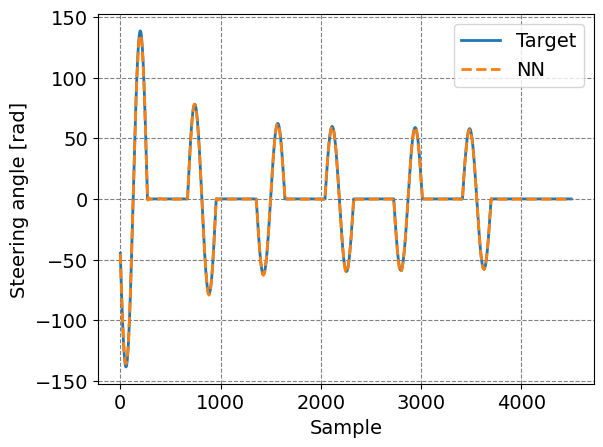

In [163]:
# Test on a new dataset
num_samples_use  = 4500
samples_test_set = mass_estimator.getSamples('validation_set', index=0, window=num_samples_use) 
mass_estimator.resetStates()  # reset the internal state
out_nn_test_set         = mass_estimator(samples_test_set, sampled=True, 
                                               prediction_samples=num_samples_use,
                                               closed_loop={'steer':'steering_angle'})
out_nn_test_set_extract = np.asarray(out_nn_test_set['steering_angle'])

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['steer_target']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['steer_target'][i]

# Compute the MSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
mse_calc = mse_calc/len(samples_test_set_extract)
print('MSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(np.rad2deg(samples_test_set_extract),label='Target',linewidth=2)
  plt.plot(np.rad2deg(out_nn_test_set_extract),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Steering angle [rad]')
  plt.legend()
  plt.grid()
  plt.show()

# Test with custom data
#mass_estimator({'curv':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'steer':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]})

## Export the trained NN

In [127]:
flag_export_trained_model = False
if flag_export_trained_model:
  # Export the model
  mass_estimator.neuralizeModel()
  mass_estimator.exportJSON()

flag_load_trained_model = False
if flag_load_trained_model:
  # Reload the trained model:
  # Load the json file with the model
  json_folder = os.path.join(os.getcwd(),'tutorials','trained_models','neu4mes_2024_10_07_17_50')
  json_file = os.path.join(json_folder,'model.json')
  import json
  # Open and read the JSON file
  with open(json_file, 'r') as file:
      model_trained_json = json.load(file)

  mass_estimator.model_def = model_trained_json
  # mass_estimator.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
  #                                  training_params=training_pars_closed_loop, optimizer='Adam', shuffle_data=True,
  #                                  prediction_samples=predict_samples, step=steps_skip,
  #                                  early_stopping=earlystopping.early_stop_valid_patience, early_stopping_params={'exit_tol':1-3})  